# Preprocessing of heat demand dataset for BASOPRA_extended

The heat demand data is used to size the heat pump according to the Appendix A and C of The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38 Part B: Buildings and Space Heat Load. Once the heat pump size is known, the inlet and outlet temperature for the three types of houses is calculated for space heating and domestic hot water. Finally, the COP is calculated for the distribution temperature and the output temperature

## TODO: Include GSHP

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import math

In [4]:
np.__version__

'1.14.2'

In [5]:
df=pd.read_csv('Input/Heat_demand.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
df.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')

According to Appendix A if the IEA SHC task 44, the distribution of the outdoor temperature is shown and the ambient design temperature is calculated

In [6]:
from scipy import optimize
def yearly_temps(times, avg, ampl, time_offset):
    return (avg
            + ampl * np.cos((times + time_offset) * 2 * np.pi / times.max()))


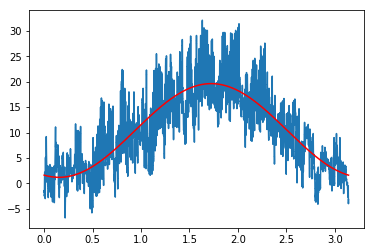

The fitting function has the form a+b*cos((x+c)*2*pi/max(x))
10.408264644698516+-9.221868237304669*cos((x+-0.1530588462336264)*2)


In [7]:
y_data=df.Temp.values
x_data=np.linspace(0,math.pi,35040)
opt_results, covariance = optimize.curve_fit(yearly_temps, x_data,
                                      y_data, [20, 10, 0])

plt.figure()
plt.plot(x_data,y_data)
plt.plot(x_data,yearly_temps(x_data, *opt_results), 'r-')#The * send the whole array a separated as if a[0],a[1],a[2] were sent
plt.show()
print('The fitting function has the form a+b*cos((x+c)*2*pi/max(x))')
print('{}+{}*cos((x+{})*2)'.format(*opt_results))


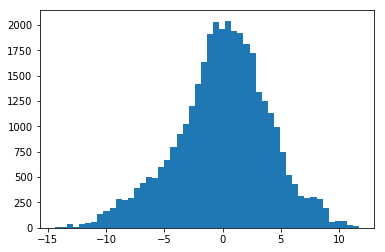

In [8]:
temp_deviation_from_sine_fit=yearly_temps(x_data,*opt_results)-y_data
plt.hist(temp_deviation_from_sine_fit,bins=50)
plt.show()

According to Appendix A "the outdoor design temperature is defined as the lowest temperature to lie in the z=2.57*sigma quantile i.e. the confidence interval of p=0.99"

In [9]:
conf_int=0.99
design_temp=np.quantile(temp_deviation_from_sine_fit,1-conf_int)

AttributeError: module 'numpy' has no attribute 'quantile'

Now the heat load is estimated according to Appendix D and taking the heat demand from the df previously loaded

In [ ]:
df_power=df.copy()
df_power.loc[:,['SFH15_kWh','SFH45_kWh','SFH100_kWh']]*=4

In [ ]:
heat_load=(df_power.groupby(df.Temp).mean()).loc[:,['SFH15_kWh','SFH45_kWh','SFH100_kWh']]
heat_load=heat_load.loc[heat_load.index<15]
z15 = np.polyfit(heat_load.index, heat_load.SFH15_kWh, 1)
z45 = np.polyfit(heat_load.index, heat_load.SFH45_kWh, 1)
z100 = np.polyfit(heat_load.index, heat_load.SFH100_kWh, 1)
fit_15=heat_load.index*z15[0]+z15[1]
fit_45=heat_load.index*z45[0]+z45[1]
fit_100=heat_load.index*z100[0]+z100[1]

In [ ]:

plt.plot(heat_load.index, fit_15,'g-',label='SFH15')
plt.plot(heat_load.index, fit_45,'r-',label='SFH45')
plt.plot(heat_load.index, fit_100,'b-',label='SFH100')
plt.plot(heat_load)
plt.legend()
plt.ylabel('Power [kW]')
plt.xlabel('Ambient Temperature [°C]')
plt.show()

In [ ]:
hl_dt15=round(design_temp*z15[0]+z15[1],3)
hl_dt45=round(design_temp*z45[0]+z45[1],3)
hl_dt100=round(design_temp*z100[0]+z100[1],3)
print('The heat load at design ambient temperature for SFH15 is:{}'.format(hl_dt15))
print('The heat load at design ambient temperature for SFH45 is:{}'.format(hl_dt45))
print('The heat load at design ambient temperature for SFH100 is:{}'.format(hl_dt100))

## Heat emission system
Taking the heat demand from the dataframe, the design ambient temperature, the design heat load and design inlet temperature, we calculate the inlet and outlet temperature depending on the outdoor temperature. These calculations are based on the section 5 of the IEA SHC task 44. For these calculations the room temperature is kept at 20°C. 

### Attention, Set_T modified

In [ ]:
df.Set_T=20

In [ ]:
dict_design={'hl_dt15':hl_dt15,'hl_dt45':hl_dt45,'hl_dt100':hl_dt100,'design_temp':design_temp,'T_din_15_45':35,'T_dout_15_45':30,'T_din_100':55,
             'T_dout_100':45,'rad_exp_15_45':1.1,'rad_exp_100':1.3}

In [ ]:
aux=df.groupby(df.index.dayofyear).mean().Temp
df.loc[(df.index.hour==0)&(df.index.minute==0),'Temp_mean']=aux.values
df.Temp_mean=df.Temp_mean.ffill()

In [ ]:
def get_inlet_outlet_temp(df, dict_design):
    '''
    Description
    ---------
    Determines the inlet temperature according to the The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38
    Part B: Buildings and Space Heat Load eq 11 pg 13 of 35. For this the ambient temperature, the set temperature and the design temperatures
    are needed
    Temperatures in Celsius or Kelvin
    Parameters
    ---------
    df: dataframe; includes ambient and set Temp as well as the heat demand for the SFH
    dict_design:dict; design temperature, design heat load, design inlet (supply) and outlet (return) temperature
    '''
    if df.Temp[0]>200:#Kelvin
        dict_design.update({'design_temp':design_temp+273.15,'T_din_15_45':35+273.15,'T_dout_15_45':30+273.15,'T_din_100':55+273.15,
             'T_dout_100':45+273.15})
    df['Temp_flow_SFH15_45']=df.Set_T+((dict_design['T_din_15_45']-dict_design['T_dout_15_45'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_15_45']+dict_design['T_dout_15_45'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_15_45'])
    df['Temp_flow_SFH100']=df.Set_T+((dict_design['T_din_100']-dict_design['T_dout_100'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_100']+dict_design['T_dout_100'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_100'])
    #df['Temp_out_SFH15_45']=df.Set_T-((dict_design['T_din_15_45']-dict_design['T_dout_15_45'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_15_45']+dict_design['T_dout_15_45'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_15_45'])
    #df['Temp_out_SFH100']=df.Set_T-((dict_design['T_din_100']-dict_design['T_dout_100'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_100']+dict_design['T_dout_100'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_100'])
    df=df.fillna(0)
    return

In [ ]:
def get_inlet_outlet_temp(df, dict_design):
    '''
    Description
    ---------
    Determines the inlet temperature according to the The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38
Part B: Buildings and Space Heat Load eq 11 pg 13 of 35. For this the ambient temperature, the set temperature and the design temperatures are needed
    Temperatures in Celsius or Kelvin
    Parameters
    ---------
    df: dataframe; includes ambient and set Temp as well as the heat demand for the SFH
    dict_design:dict; design temperature, design heat load, design inlet (supply) and outlet (return) temperature
    '''
    if df.Temp[0]>200:#Kelvin
        dict_design.update({'design_temp':design_temp+273.15,'T_din_15_45':35+273.15,'T_dout_15_45':30+273.15,'T_din_100':55+273.15,
             'T_dout_100':45+273.15})
    df['Temp_in_SFH15_45']=df.Set_T+((dict_design['T_din_15_45']-dict_design['T_dout_15_45'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_15_45']+dict_design['T_dout_15_45'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_15_45'])
    df['Temp_in_SFH100']=df.Set_T+((dict_design['T_din_100']-dict_design['T_dout_100'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_100']+dict_design['T_dout_100'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_100'])
    df['Temp_out_SFH15_45']=df.Set_T-((dict_design['T_din_15_45']-dict_design['T_dout_15_45'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_15_45']+dict_design['T_dout_15_45'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_15_45'])
    df['Temp_out_SFH100']=df.Set_T-((dict_design['T_din_100']-dict_design['T_dout_100'])/2*(df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))+((dict_design['T_din_100']+dict_design['T_dout_100'])/2-df.Set_T)*((df.Set_T-df.Temp_mean)/(df.Set_T-dict_design['design_temp']))**(1/dict_design['rad_exp_100'])
    df=df.fillna(0)
    return

In [ ]:
print(dict_design)

In [ ]:
def find_interval_hp(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''

    for i in range(0, len(partition)):
        if x <= partition[i]:
            return i
    if x >partition[i]:
        return i

In [ ]:
get_inlet_outlet_temp(df, dict_design)


In [ ]:
df_inlet=(df.groupby(df.Temp_mean.round()).mean())
df_inlet=df_inlet.loc[:,['Temp_flow_SFH15_45','Temp_flow_SFH100','Temp_return_SFH15_45','Temp_return_SFH100']]
df_inlet.plot()
plt.show()

In [ ]:
df.head()

In [ ]:
df_hp=pd.read_csv('Input/HP_data.csv',sep=';')# Temperature in celcius
df_hp.loc[:,'P_el']=df_hp.loc[:,'P_el'].str.replace(',','.').astype(float)
df_hp.loc[:,'COP']=df_hp.loc[:,'COP'].str.replace(',','.').astype(float)
df_hp['P_th']=df_hp.P_el*df_hp.COP

In [ ]:
df_hp.head()

In [ ]:
df.isnull().sum()

In [ ]:
df=df.fillna(0)

In [ ]:
df['Temp_flow_SFH15_45_real']=df.apply(lambda x: df_hp.T_dist.unique()[find_interval_hp(x.Temp_flow_SFH15_45,df_hp.T_dist.unique())],axis=1)
df['Temp_flow_SFH100_real']=df.apply(lambda x: df_hp.T_dist.unique()[find_interval_hp(x.Temp_flow_SFH100,df_hp.T_dist.unique())],axis=1)
df['Temp_amb_interval']=df.apply(lambda x: df_hp.T_outside.unique()[find_interval_hp(x.Temp,df_hp.T_outside.unique())],axis=1)

In [ ]:
def hp_sizing(dict_design,df_hp):
    '''
    Get the HP rating according to the design temperature (in the interval of the input HP data) and the inlet temperature design.
    It returns the HP rating that provides the closest power to the required, if the HP cannot provide the required heat power, a backup 
    heater is required.
    '''
    desig_temp_hp_data=df_hp.T_outside.unique()[find_interval_hp(dict_design['design_temp'],df_hp.T_outside.unique())]    
    hp_15=df_hp.loc[abs(df_hp.loc[(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_din_15_45'])].P_th-dict_design['hl_dt15']).idxmin,'HP_rating']
    hp_45=df_hp.loc[abs(df_hp.loc[(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_din_15_45'])].P_th-dict_design['hl_dt45']).idxmin,'HP_rating']
    hp_100=df_hp.loc[abs(df_hp.loc[(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_din_100'])].P_th-dict_design['hl_dt100']).idxmin,'HP_rating']
    bu_100=np.ceil(max(0,dict_design['hl_dt100']-df_hp.loc[(df_hp.HP_rating==hp_100)&(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_din_100']),'P_th'].values[0]))
    bu_45=np.ceil(max(0,dict_design['hl_dt45']-df_hp.loc[(df_hp.HP_rating==hp_45)&(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_din_15_45']),'P_th'].values[0]))
    bu_15=np.ceil(max(0,dict_design['hl_dt15']-df_hp.loc[(df_hp.HP_rating==hp_15)&(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_din_15_45']),'P_th'].values[0]))
    dict_design.update({'hp_15':hp_15,'hp_45':hp_45,'hp_100':hp_100,'bu_15':bu_15,'bu_45':bu_45,'bu_100':bu_100})
    return

In [ ]:
hp_sizing(dict_design,df_hp)

In [ ]:
dict_design

In [ ]:
df[df.index.dayofyear<100].head().min()

In [ ]:
df[df.index.dayofyear<100].Temp_flow_SFH15_45.plot()

In [ ]:
def get_COP(df,df_hp,dict_design):
    '''
    Calculates the COP for the three house types as well as the hp consumption (electricity) according to the HP rating, inlet temperature 
    and ambient temperature
    TODO
    -----
    include dt (here 15 minutes)
    '''
    df['COP_SFH15']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==x.Temp_flow_SFH15_45_real)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH45']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==x.Temp_flow_SFH15_45_real)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH100']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.Temp_flow_SFH100_real)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    
    df['COP_SFH15_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH45_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    df['COP_SFH100_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    
    df['hp_SFH15_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==x.Temp_flow_SFH15_45_real)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0]/4,axis=1)
    df['hp_SFH45_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==x.Temp_flow_SFH15_45_real)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0]/4,axis=1)
    df['hp_SFH100_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.Temp_flow_SFH100_real)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0]/4,axis=1)
    
    df['hp_SFH15_cons_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_15'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0]/4,axis=1)
    df['hp_SFH45_cons_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_45'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0]/4,axis=1)
    df['hp_SFH100_cons_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0]/4,axis=1)
    return

In [ ]:
get_COP(df,df_hp,dict_design)

In [ ]:
df.head()

In [ ]:
df.keys()

In [ ]:
cols=['Hour', 'Set_T', 'Temp', 'SFH15_kWh', 'SFH45_kWh', 'SFH100_kWh',
       'DHW_kWh', 'Temp_mean', 'Temp_flow_SFH15_45', 'Temp_flow_SFH100',
       'Temp_out_SFH15_45', 'Temp_out_SFH100', 'COP_SFH15', 'COP_SFH45', 'COP_SFH100',
       'COP_SFH15_DHW', 'COP_SFH45_DHW', 'COP_SFH100_DHW', 'hp_SFH15_cons',
       'hp_SFH45_cons', 'hp_SFH100_cons', 'hp_SFH15_cons_DHW',
       'hp_SFH45_cons_DHW', 'hp_SFH100_cons_DHW']

In [ ]:
df_out=df.loc[:,cols]

In [ ]:
#df_out.to_csv('Input/preprocessed_heat_demand.csv',sep=';')

In [ ]:
df_out.head()

In [ ]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
#save_obj(dict_design,'dict_design')

In [ ]:
df_out.keys()

In [ ]:
(df_out.Temp_flow_SFH100-df_out.Temp_return_SFH100).plot()

In [ ]:
(df_out.Temp_out_SFH100).plot()

In [ ]:
(df_out.COP_SFH100).plot()

In [ ]:
df_out.loc[:,['Temp_flow_SFH100','Temp_return_SFH100','COP_SFH100','COP_SFH100_DHW','hp_SFH100_cons','hp_SFH100_cons_DHW']]

In [ ]:
dict_design